# <font color = 'indianred'>**Emotion Detection - MultiLabel** </font>

**Plan**

1. Set Environment
2. Load Dataset
3. Load Pre-trained Tokenizer
4. Train Model
     1. Compute Metric Function <br>
     2. Training Arguments <br>
     3. Specify Model
     4. Instantiate Trainer <br>
     5. Setup WandB <br>
     6. Training and Validation






















# <font color = 'indianred'> **1. Setting up the Environment** </font>



In [1]:
# If in Colab, then import the drive module from google.colab
import sys
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  # !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate peft bitsandbytes -U -qq ## NEW LINES ##
  basepath = '/content/drive/MyDrive/Colab_Notebooks/BUAN_6342_Applied_Natural_Language_Processing'
  sys.path.append('/content/drive/MyDrive/Colab_Notebooks/BUAN_6342_Applied_Natural_Language_Processing/0_Custom_files')
else:
  basepath = '/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6342_Applied_Natural_Language_Processing/'
  sys.path.append('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6342_Applied_Natural_Language_Processing/0_Custom_files')

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 82.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 30.1 MB/s 

<font color = 'indianred'> *Load Libraries* </font>

In [2]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import (
    TrainingArguments,
    Trainer,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    BitsAndBytesConfig,
)

import wandb
import evaluate

In [3]:
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
)

# <font color = 'indianred'> **2. Load_Dataset** </font>

In [4]:
emotion_data = load_dataset('harpreetmann/train_emotion_spring_2024')

Generating train split:   0%|          | 0/6179 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [5]:
emotion_data['train'][0:2]

{'text': ['Does anyone know, are both Sims in a dual sim phone both locked to the same network! #worry',
  'A not very young man compiled info on a smiling baby then a mattress created new evil.'],
 'label': [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
  [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]}

In [6]:
labels = ['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

# <font color = 'indianred'>**3. Load pre-trained Tokenizer**</font>



In [7]:
checkpoint = "Alibaba-NLP/gte-Qwen1.5-7B-instruct"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True)

<font color = 'indianred'> *Use map function to apply tokenization to all splits*

In [9]:
tokenized_dataset= emotion_data.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
# tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [10]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1545
    })
})

#  <font color = 'indianred'> **4. Model Training**

##  <font color = 'indianred'> **4.1. compute_metrics function** </font>



In [11]:
accuracy_metric = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # logits= logits[0]
    # print(logits.shape)
    preds = (logits > 0).astype(int)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy':accuracy['accuracy'],
            }

## <font color = 'indianred'> **4.2. Training Arguments**</font>







In [12]:
# Define the directory where model checkpoints will be saved
run_name = "emotions_qwen_qlora_im"
base_folder = Path(basepath)
model_folder = base_folder / "models"/run_name
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=5,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    # gradient_accumulation_steps=4,

    weight_decay=0.1,  # Apply L2 regularization to prevent overfitting
    learning_rate=5e-6,  # Step size for the optimizer during training
    lr_scheduler_type='linear',
    warmup_steps=0,  # Number of warmup steps for the learning rate scheduler
    optim='paged_adamw_32bit',  # Optimizer,
    max_grad_norm = 1.0,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name=run_name,  # Experiment name for Weights & Biases

    fp16=False,
    bf16=True,
    tf32= False
)


## <font color = 'indianred'> **4.3. Specify Model**</font>

In [ ]:
# BitsAndBytesConfig??

In [13]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  llm_int8_skip_modules = ['score'],
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch.bfloat16
)

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels=11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config)

model = prepare_model_for_kbit_training(model)

config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(labels)}
label2id = {label_: id_ for id_, label_ in enumerate(labels)}
config.id2label = id2label
config.label2id = label2id
model.config = config
model


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/879 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/31.7k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/3.93G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/4.05G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/4.05G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/4.05G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/4.05G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/4.05G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/4.05G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at Alibaba-NLP/gte-Qwen1.5-7B-instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Qwen2ForSequenceClassification(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 4096)
    (layers): ModuleList(
      (0-31): 32 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=True)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=True)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=True)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm()
        (post_attention_layernorm): Qwen2RMSNorm()
      )
    )
   

In [15]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config

Qwen2Config {
  "_name_or_path": "Alibaba-NLP/gte-Qwen1.5-7B-instruct",
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "auto_map": {
    "AutoModel": "Alibaba-NLP/gte-Qwen1.5-7B-instruct--modeling_qwen.Qwen2Model",
    "AutoModelForCausalLM": "Alibaba-NLP/gte-Qwen1.5-7B-instruct--modeling_qwen.Qwen2ForCausalLM",
    "AutoModelForSequenceClassification": "Alibaba-NLP/gte-Qwen1.5-7B-instruct--modeling_qwen.Qwen2ForSequenceClassification"
  },
  "bos_token_id": 151643,
  "eos_token_id": 151643,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimis

In [16]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [17]:
# prompt: pass two observations from tokenized dataset to datacollatior

batch = [tokenized_dataset['train'][0], tokenized_dataset['train'][1]]
batch = data_collator(batch)
batch


{'input_ids': tensor([[ 21468,   5489,   1414,     11,    525,   2176,  51623,    304,    264,
          18579,   1643,   4540,   2176,  16061,    311,    279,   1852,   3922,
              0,    671,     86,   8468],
        [    32,    537,   1602,   3908,    883,  19697,   3546,    389,    264,
          36063,   8770,   1221,    264,  32226,   3465,    501,  13962,     13,
         151643, 151643, 151643, 151643]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]]), 'labels': tensor([[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.],
        [1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])}

In [18]:
input_ids = batch['input_ids']
input_ids

tensor([[ 21468,   5489,   1414,     11,    525,   2176,  51623,    304,    264,
          18579,   1643,   4540,   2176,  16061,    311,    279,   1852,   3922,
              0,    671,     86,   8468],
        [    32,    537,   1602,   3908,    883,  19697,   3546,    389,    264,
          36063,   8770,   1221,    264,  32226,   3465,    501,  13962,     13,
         151643, 151643, 151643, 151643]])

In [19]:
pad_token_id = 2

In [20]:
sequence_lengths = torch.eq(input_ids, pad_token_id).int().argmax(-1) - 1

In [21]:
sequence_lengths

tensor([-1, -1])

In [22]:
import re
model_modules = str(model.modules)
pattern = r'\((\w+)\): Linear'
linear_layer_names = re.findall(pattern, model_modules)

names = []
# Print the names of the Linear layers
for name in linear_layer_names:
    names.append(name)
target_modules = list(set(names))
target_modules

['k_proj',
 'down_proj',
 'q_proj',
 'o_proj',
 'up_proj',
 'v_proj',
 'score',
 'gate_proj']

In [ ]:
# LoraConfig??

In [23]:
mistral_peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    bias="lora_only",
    modules_to_save = ['score'],
    target_modules = ['k_proj',
 'down_proj',
 'q_proj',
 'o_proj',
 'up_proj',
 'v_proj',
 'gate_proj'])

mistral_qlora_model = get_peft_model(model, mistral_peft_config )
# mistral_qlora_model.config.pad_token_id = tokenizer.pad_token_id
# mistral_qlora_model.resize_token_embeddings(len(tokenizer))
mistral_qlora_model.print_trainable_parameters()

trainable params: 320,253,952 || all params: 7,418,900,480 || trainable%: 4.316730664649649


In [24]:
mistral_peft_config.target_modules

{'down_proj', 'gate_proj', 'k_proj', 'o_proj', 'q_proj', 'up_proj', 'v_proj'}

In [25]:
mistral_qlora_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): Qwen2ForSequenceClassification(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 4096)
        (layers): ModuleList(
          (0-31): 32 x Qwen2DecoderLayer(
            (self_attn): Qwen2SdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
       

##  <font color = 'indianred'> **4.4 Custom Trainer**</font>



In [26]:
def calculate_pos_weights(dataset):
    # Initialize counters for all labels
    num_labels = len(dataset['train']['label'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    # Count positives and negatives for each label
    for label_array in dataset['train']['label']:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    # Calculate pos_weight for each label
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

# Calculate the pos_weight using the training set
pos_weights = calculate_pos_weights(emotion_data)


In [27]:
pos_weights

tensor([ 1.6795,  5.9349,  1.6519,  4.7002,  1.6947,  8.4192,  2.3988,  7.6541,
         2.3400, 18.6783, 19.1928])

In [28]:
pos_weights= torch.tensor([2., 3., 2., 2., 2., 3., 2., 3., 2., 4., 4.])

In [29]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [30]:
mistral_qlora_model.config

Qwen2Config {
  "_name_or_path": "Alibaba-NLP/gte-Qwen1.5-7B-instruct",
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "auto_map": {
    "AutoModel": "Alibaba-NLP/gte-Qwen1.5-7B-instruct--modeling_qwen.Qwen2Model",
    "AutoModelForCausalLM": "Alibaba-NLP/gte-Qwen1.5-7B-instruct--modeling_qwen.Qwen2ForCausalLM",
    "AutoModelForSequenceClassification": "Alibaba-NLP/gte-Qwen1.5-7B-instruct--modeling_qwen.Qwen2ForSequenceClassification"
  },
  "bos_token_id": 151643,
  "eos_token_id": 151643,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimis

In [31]:
trainer = CustomTrainer(
    model=mistral_qlora_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

## <font color = 'indianred'> **4.5 Setup WandB**</font>

In [32]:
if 'google.colab' in str(get_ipython()):
    from google.colab import userdata
    wandb.login(key=userdata.get('wandb'))
else:
    !wandb login

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [33]:
# wandb.login()
%env WANDB_PROJECT = nlp_course_spring_2024-emotion-analysis-hf-trainer-hw8

env: WANDB_PROJECT=nlp_course_spring_2024-emotion-analysis-hf-trainer-hw8


## <font color = 'indianred'> **4.6. Start Training**</font>

In [34]:
trainer.train()  # start training

wandb: Currently logged in as: harikrish0607 (harikrishnad). Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
20,1.991800,1.528167,0.378145,0.296223,0.007120
40,1.349600,1.094870,0.395479,0.326656,0.009709
60,0.994200,0.841469,0.454304,0.336307,0.038188
80,0.742400,0.723674,0.520524,0.389709,0.064725
100,0.668200,0.661581,0.577701,0.418749,0.100324
120,0.648700,0.633826,0.597916,0.440131,0.100971
140,0.612800,0.601893,0.622955,0.474028,0.122330
160,0.608900,0.580478,0.628405,0.502808,0.113269
180,0.566700,0.572974,0.641573,0.516007,0.126214
200,0.558400,0.563882,0.649289,0.512388,0.163107


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=T

TrainOutput(global_step=970, training_loss=0.5092890230650754, metrics={'train_runtime': 2447.9976, 'train_samples_per_second': 12.621, 'train_steps_per_second': 0.396, 'total_flos': 5.71731191039017e+16, 'train_loss': 0.5092890230650754, 'epoch': 5.0})

## <font color = 'indianred'> **4.7. Validation**</font>


In [35]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [36]:
eval_results

{'eval_loss': 0.5099042654037476,
 'eval_f1_micro': 0.6852060628836277,
 'eval_f1_macro': 0.5984361856130597,
 'eval_accuracy': 0.18122977346278318,
 'eval_runtime': 15.3173,
 'eval_samples_per_second': 100.866,
 'eval_steps_per_second': 3.199,
 'epoch': 5.0}

In [37]:
wandb.log({"eval_accuracy": eval_results["eval_accuracy"], "eval_loss": eval_results["eval_loss"],
"eval_f1_micro": eval_results["eval_f1_micro"], "eval_f1_macro": eval_results["eval_f1_macro"]})

###  <font color = 'indianred'> **Check Confusion Matrix**</font>




In [38]:
# Use the trainer to generate predictions on the tokenized validation dataset.
# The resulting object, valid_output, will contain the model's logits (raw prediction scores) for each input in the validation set.
valid_output = trainer.predict(tokenized_dataset["valid"])

In [39]:
valid_output.predictions.shape

(1545, 11)

In [40]:
predictions_valid = (valid_output.predictions > 0).astype(int)
labels_valid = valid_output.label_ids.astype(int)

In [41]:
predictions_valid

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0]])

In [42]:
predictions_valid.shape

(1545, 11)

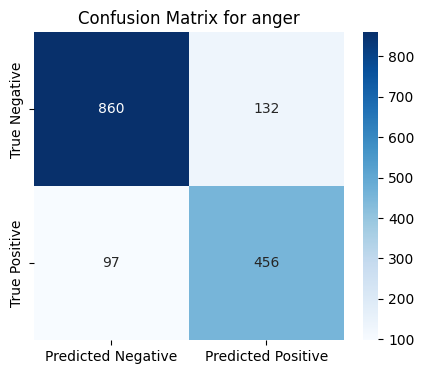

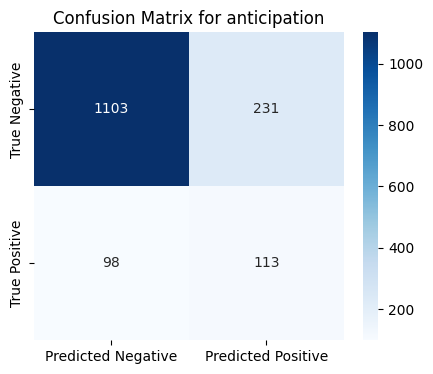

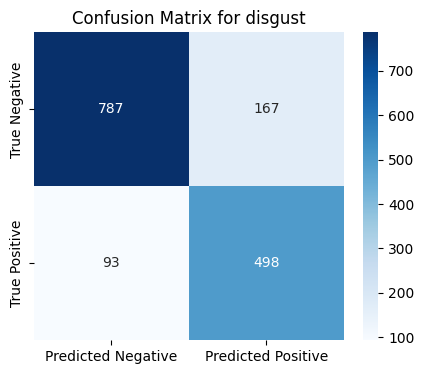

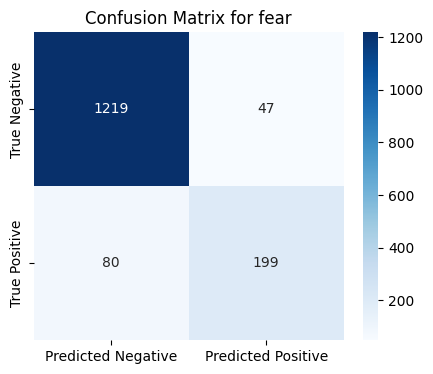

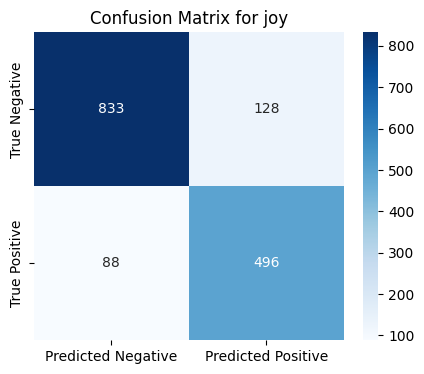

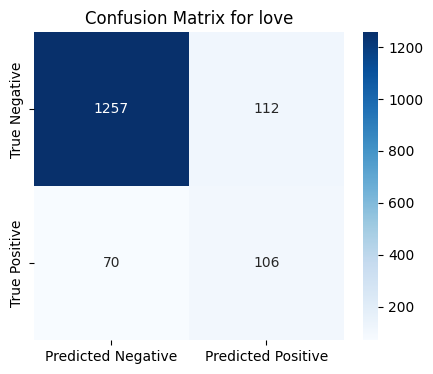

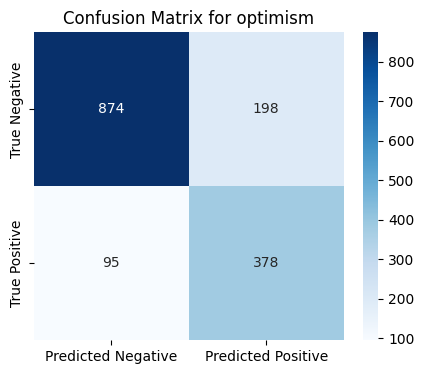

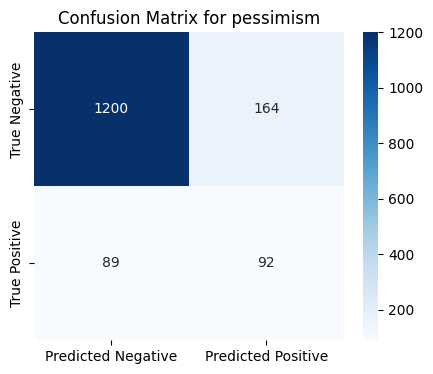

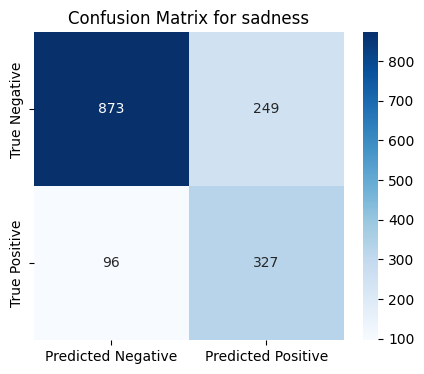

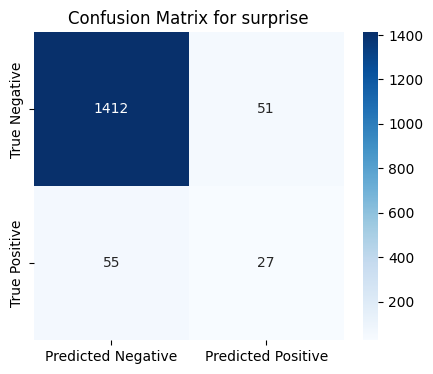

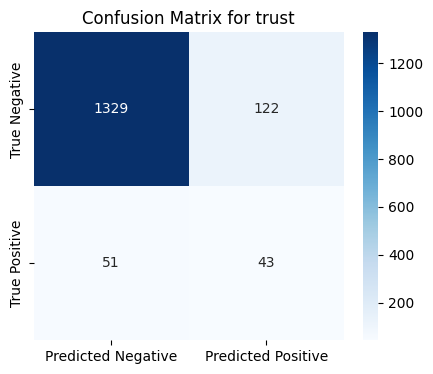

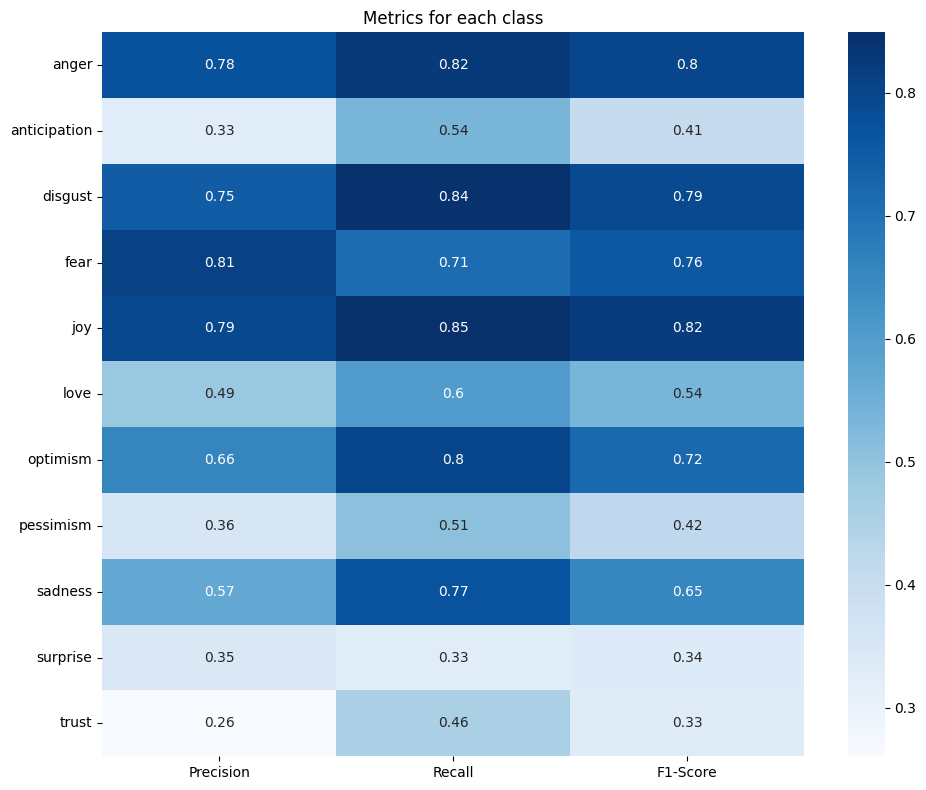

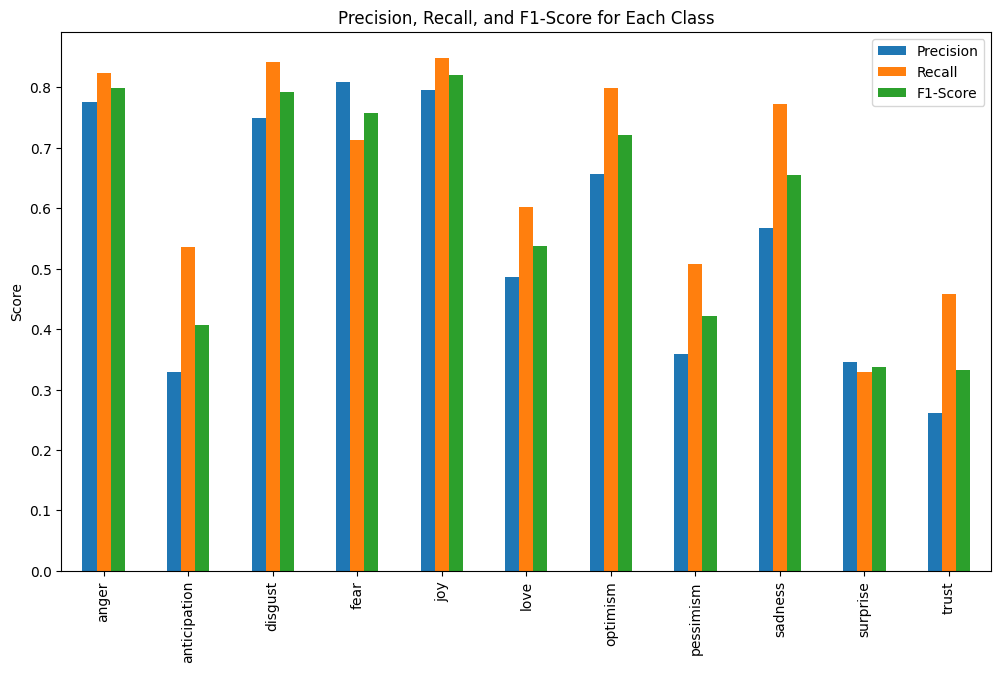

In [43]:
y_true = labels_valid
y_pred = predictions_valid
class_names = labels

mcm = multilabel_confusion_matrix(y_true, y_pred,)

# 1. Individual Heatmaps
for idx, matrix in enumerate(mcm):
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['True Negative', 'True Positive'])
    plt.title(f'Confusion Matrix for {class_names[idx]}')
    plt.show()

# 2. Aggregate Metrics Heatmap
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
}, index=class_names)

plt.figure(figsize=(10, 8))
# sns.heatmap(metrics_df, annot=True, cmap='Blues')
# plt.title('Metrics for each class')
# plt.show()

ax = sns.heatmap(metrics_df, annot=True, cmap='Blues')
plt.title('Metrics for each class')
plt.tight_layout()  # Adjust layout to not cut off edges

# Log the heatmap to wandb
wandb.log({"Metrics Heatmap": wandb.Image(ax.get_figure())})
plt.show()

# 3. Histogram of Metrics
metrics_df.plot(kind='bar', figsize=(12, 7))
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.show()




In [44]:
wandb.finish()

eval/accuracy,▁▁▂▃▄▅▅▅▆▇▇▆▆█▇▇█▇█▇█▇███▇███▇█▇██▇█▇▇▇▇
eval/f1_macro,▁▂▂▃▄▅▆▆▆▆▇▇▇▇▇▇▇█▇█████████████████████
eval/f1_micro,▁▁▃▄▅▆▇▇▇▇▇▇▇███████████████████████████
eval/loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,▁▂▅▅█▂▂▂▄▄▆▃▃▂▂▄▂▁▃▇▂▂▅▂▂▃▆▃▃▄▅▃▃▃▃▄▄▅▆▂
eval/samples_per_second,█▇▄▄▁▇▇▇▅▅▃▆▆▇▇▅▇█▆▂▇▇▄▇▇▆▃▆▆▅▄▆▆▆▆▅▅▄▃▇
eval/steps_per_second,█▇▄▄▁▇▇▇▅▅▃▆▆▇▇▄▇█▆▂▇▇▄▇▇▆▃▆▆▅▃▆▆▆▆▅▅▄▃▇
eval_accuracy,▁
eval_f1_macro,▁
eval_f1_micro,▁
eval_loss,▁


In [45]:
import os
# from huggingface_hub import notebook_login
from google.colab import userdata
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

In [46]:
mistral_qlora_model.push_to_hub("harikrishnad1997/qwen_QLORA_model_emotion_detection")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


adapter_model.safetensors:   0%|          | 0.00/1.28G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/harikrishnad1997/qwen_QLORA_model_emotion_detection/commit/34611ea147b41c7c57cc134baffb6a467e5f619d', commit_message='Upload model', commit_description='', oid='34611ea147b41c7c57cc134baffb6a467e5f619d', pr_url=None, pr_revision=None, pr_num=None)

In [47]:
test = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/BUAN_6342_Applied_Natural_Language_Processing/HW/test.csv')
test.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
1,2018-03739,"Academy of Sciences, eschews the normally sobe...",NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
2,2018-00385,I blew that opportunity -__- #mad,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3,2018-03001,This time in 2 weeks I will be 30... 😥,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
4,2018-01988,#Deppression is real. Partners w/ #depressed p...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE


In [48]:
test.shape

(3259, 13)

In [49]:
from datasets import Dataset
testset = Dataset.from_dict({
    'text': test['Tweet']})

In [50]:
tokenized__test_dataset= testset.map(tokenize_fn, batched=True)
tokenized_test_dataset = tokenized__test_dataset.remove_columns(
    ['text']
)

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [51]:
predictions = trainer.predict(tokenized_test_dataset)

In [52]:
predictions

PredictionOutput(predictions=array([[ 0.3203125 , -1.921875  ,  0.32421875, ..., -1.90625   ,
        -6.0625    , -1.6796875 ],
       [-0.515625  , -0.72265625, -1.1015625 , ...,  1.7265625 ,
        -2.9375    , -3.828125  ],
       [ 4.46875   , -4.375     ,  3.015625  , ...,  1.7578125 ,
        -4.1875    , -7.5625    ],
       ...,
       [ 4.46875   , -1.5703125 ,  2.765625  , ..., -0.91015625,
        -2.234375  , -4.40625   ],
       [-4.46875   , -1.0859375 , -5.28125   , ..., -2.15625   ,
        -0.08398438, -0.8359375 ],
       [-2.578125  ,  1.3359375 , -3.15625   , ..., -4.71875   ,
        -2.03125   , -1.890625  ]], dtype=float32), label_ids=None, metrics={'test_runtime': 31.4645, 'test_samples_per_second': 103.577, 'test_steps_per_second': 3.242})

In [53]:
predictions.predictions.shape

(3259, 11)

In [54]:
predictions_test = pd.DataFrame((predictions.predictions > 0).astype(int), columns=labels)
predictions_test

,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,1,0,1,1,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,1,1,0,0
2,1,0,1,0,0,0,0,0,1,0,0
3,0,1,0,1,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3254,1,0,1,0,0,0,0,0,1,0,0
3255,0,1,0,0,0,0,0,0,0,0,0
3256,1,0,1,0,0,0,0,0,0,0,0
3257,0,0,0,0,1,1,1,0,0,0,0


In [55]:
test.columns

Index(['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
      dtype='object')

In [56]:
test = pd.concat([test['ID'], predictions_test], axis=1)
test.to_csv('submission.csv', index=False)

In [57]:
from google.colab import userdata
!rm -rf /root/.kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
api_token = {"username":userdata.get('KAGGLE_USERNAME'),"key":userdata.get('KAGGLE_KEY')}
import json
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json

In [58]:
from kaggle import api
comp = 'emotion-detection-spring2014'
api.competition_submit('submission.csv', 'mistral_SFR_2024_05_03', comp)

100%|██████████| 105k/105k [00:00<00:00, 135kB/s]


ApiException: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Content-Type': 'application/json', 'Date': 'Tue, 07 May 2024 22:57:38 GMT', 'Access-Control-Allow-Credentials': 'true', 'Access-Control-Allow-Origin': '*', 'Set-Cookie': 'ka_sessionid=9aab34eb82697d9740fc9a6cae675131; max-age=2626560; path=/, GCLB=CPHyq_7a6b_WtQEQAw; path=/; HttpOnly', 'Transfer-Encoding': 'chunked', 'Vary': 'Accept-Encoding', 'Turbolinks-Location': 'https://www.kaggle.com/api/v1/competitions/submissions/submit/emotion-detection-spring2014', 'X-Kaggle-MillisecondsElapsed': '195', 'X-Kaggle-RequestId': '8f209c7628ee9776e49f6c92e2df961b', 'X-Kaggle-ApiVersion': '1.6.12', 'X-Kaggle-HubVersion': '0.2.5', 'X-Frame-Options': 'SAMEORIGIN', 'Strict-Transport-Security': 'max-age=63072000; includeSubDomains; preload', 'Content-Security-Policy': "object-src 'none'; script-src 'nonce-T2I7CS+rBVmPlIt+kAli+Q==' 'report-sample' 'unsafe-inline' 'unsafe-eval' 'strict-dynamic' https: http:; base-uri 'none'; report-uri https://csp.withgoogle.com/csp/kaggle/20201130; frame-src 'self' https://www.kaggleusercontent.com https://www.youtube.com/embed/ https://polygraph-cool.github.io https://www.google.com/recaptcha/ https://www.docdroid.com https://www.docdroid.net https://kaggle-static.storage.googleapis.com https://kkb-production.jupyter-proxy.kaggle.net https://kkb-production.firebaseapp.com https://kaggle-metastore.firebaseapp.com https://apis.google.com https://content-sheets.googleapis.com/ https://accounts.google.com/ https://storage.googleapis.com https://docs.google.com https://drive.google.com https://calendar.google.com/;", 'X-Content-Type-Options': 'nosniff', 'Referrer-Policy': 'strict-origin-when-cross-origin', 'Via': '1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000'})
HTTP response body: {"code":400,"message":"Submission not allowed:  Your team has used its daily Submission allowance (5) today, please try again tomorrow UTC (62 minutes from now)."}
